In [38]:
from transforms import *
from torchvision.transforms import *
import librosa
import utils.config as config
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from functools import partial
from datasets.librispeech import convert_to_mel
import soundfile
import resampy

def tensor_to_img(spectrogram):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.tight_layout()

In [39]:
# audio_path = '/Users/audio.wav'
audio_path = '/Users/audio.wav'
audio, original_sampling_rate = soundfile.read(audio_path, dtype='float32')
audio = resampy.resample(audio, 16000, original_sampling_rate, axis=-1)
# audio, _ = librosa.core.load(audio_path, sr=16000)
data = {'samples': audio, 'sample_rate': config.sampling_rate, 'epoch': 0}

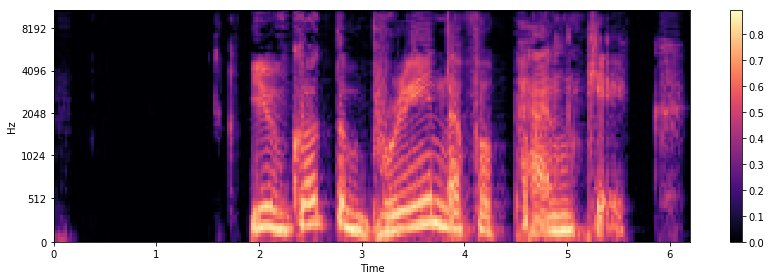

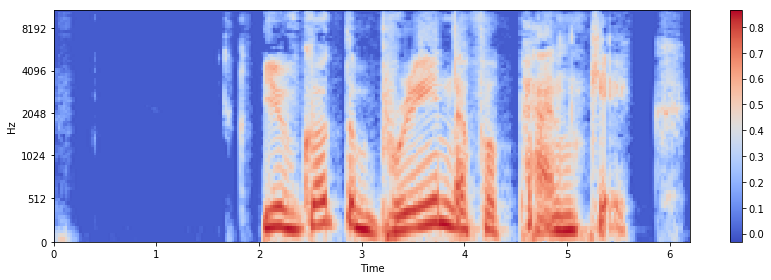

In [41]:
def get_mel(audio):
    return convert_to_mel(audio.reshape(1, -1))

def image_train_transform(signal, epoch=config.augment_warmup_epoch*0.1):
    data = {'mel_spectrogram': get_mel(signal), 'sample_rate': config.sampling_rate, 'epoch': epoch}
    transforms = Compose([SpecAugmentOnMel(), ToAudioTensor(['mel_spectrogram'])])
    return transforms(data)

spec_dctts_orig = get_mel(audio)
tensor_to_img(spec_dctts)
spec_dctts_modified = image_train_transform(signal)
tensor_to_img(spec_dctts_modified)

In [17]:
def blur_signal(signal):
    data = {'samples': signal.squeeze(0), 'sample_rate': config.sampling_rate}
    to_stft = ToSTFT(n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.window_length)
    transforms = Compose([to_stft, SpecBlurring(type='stft'), ToAudioTensor(['stft'])])
    blurred_spec = transforms(data)
    blurred_signal = librosa.core.istft(blurred_spec, hop_length=config.hop_length, win_length=config.window_length)
    return blurred_signal

In [18]:
import IPython.display as ipd
ipd.Audio(signal, rate=config.sampling_rate)

In [20]:
blurred_signal = blur_signal(signal)
ipd.Audio(blurred_signal, rate=config.sampling_rate)

Total params: 38.13M


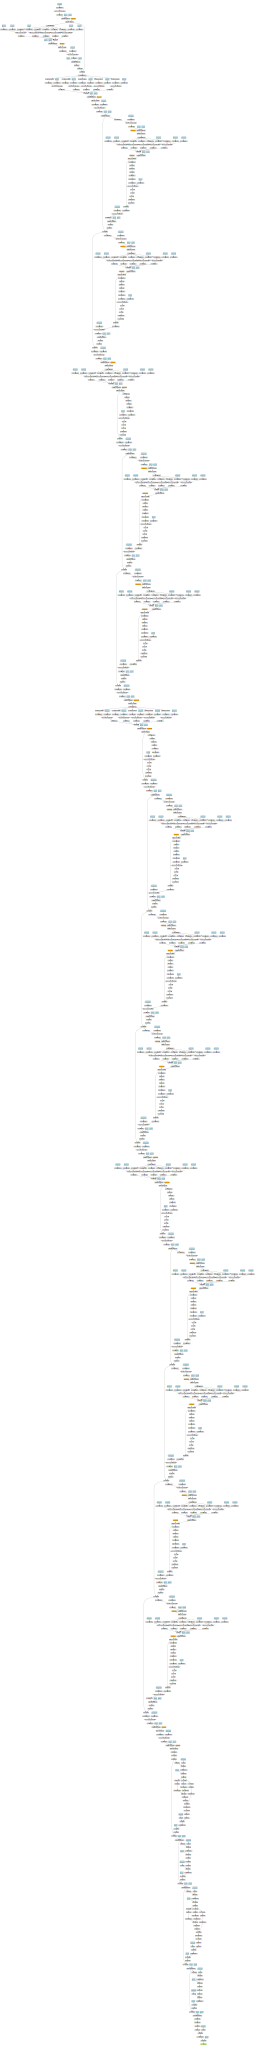

In [1]:
import torch
from torchviz import make_dot
from models.mixnet import ASRModel
from utils import config
net = ASRModel(input_features=80, num_classes=128)
print('Total params: %.2fM' % (sum(p.numel() for p in net.parameters())/1000000.0))
image = torch.randn(1, 80, 500)
y = net(image)
make_dot(y)